# Table Detection Using Detectron2
This notebook illustrates table detection using the `detectron2` model on a tricky PDF file.  The approach is to leverage the `unstructured-inference` library, unfortunately results are not conclusive (table wasn't detected).

⚠ You will have to restart the session in Colab after installing python dependencies ⚠

In [ ]:
#@title Install System Dependencies
!apt update
!apt install -qq -y libmagic-dev poppler-utils tesseract-ocr libreoffice pandoc

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [713 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,073 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ub

In [ ]:
#@title Install Python Dependencies
!pip install huggingface_hub hf-transfer unstructured-inference 'git+https://github.com/facebookresearch/detectron2.git@57bdb21249d5418c130d54e2ebdc94dda7a4c01a'

  Cloning https://github.com/facebookresearch/detectron2.git (to revision 57bdb21249d5418c130d54e2ebdc94dda7a4c01a) to /tmp/pip-req-build-0khvpj91
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-0khvpj91
  Running command git rev-parse -q --verify 'sha^57bdb21249d5418c130d54e2ebdc94dda7a4c01a'
  Running command git fetch -q https://github.com/facebookresearch/detectron2.git 57bdb21249d5418c130d54e2ebdc94dda7a4c01a
  Running command git checkout -q 57bdb21249d5418c130d54e2ebdc94dda7a4c01a
  Resolved https://github.com/facebookresearch/detectron2.git to commit 57bdb21249d5418c130d54e2ebdc94dda7a4c01a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#@title Set Environment Variables
%env HF_HUB_ENABLE_HF_TRANSFER=1

env: HF_HUB_ENABLE_HF_TRANSFER=1


In [ ]:
#@title Download Test File
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = hf_hub_download(repo_id="DataForGood/taxobservatory-pdfs", repo_type="dataset", filename="Acciona_2020_CbCR_1.pdf")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#@title Convert PDF to Images
import tempfile
from unstructured_inference.inference.layout import (
      convert_pdf_to_image,
      process_file_with_model,
      PageLayout,
  )

temp_dir = tempfile.mkdtemp()
image_paths = convert_pdf_to_image(
    file_path,
    300,
    temp_dir,
    path_only=True
)

In [ ]:
#@title Plotting Functions
import pprint
from matplotlib import pyplot as plt
from PIL import Image

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, elements):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100

    for e, c  in zip(elements, colors):
        ax.add_patch(plt.Rectangle((e.bbox.x1, e.bbox.y1), e.bbox.x2 - e.bbox.x1, e.bbox.y2 - e.bbox.y1,
                                   fill=False, color=c, linewidth=3))
        text = f'{e.type}: {e.prob:0.2f}'
        ax.text(e.bbox.x1, e.bbox.y1, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

model.onnx:   0%|          | 0.00/166M [00:00<?, ?B/s]

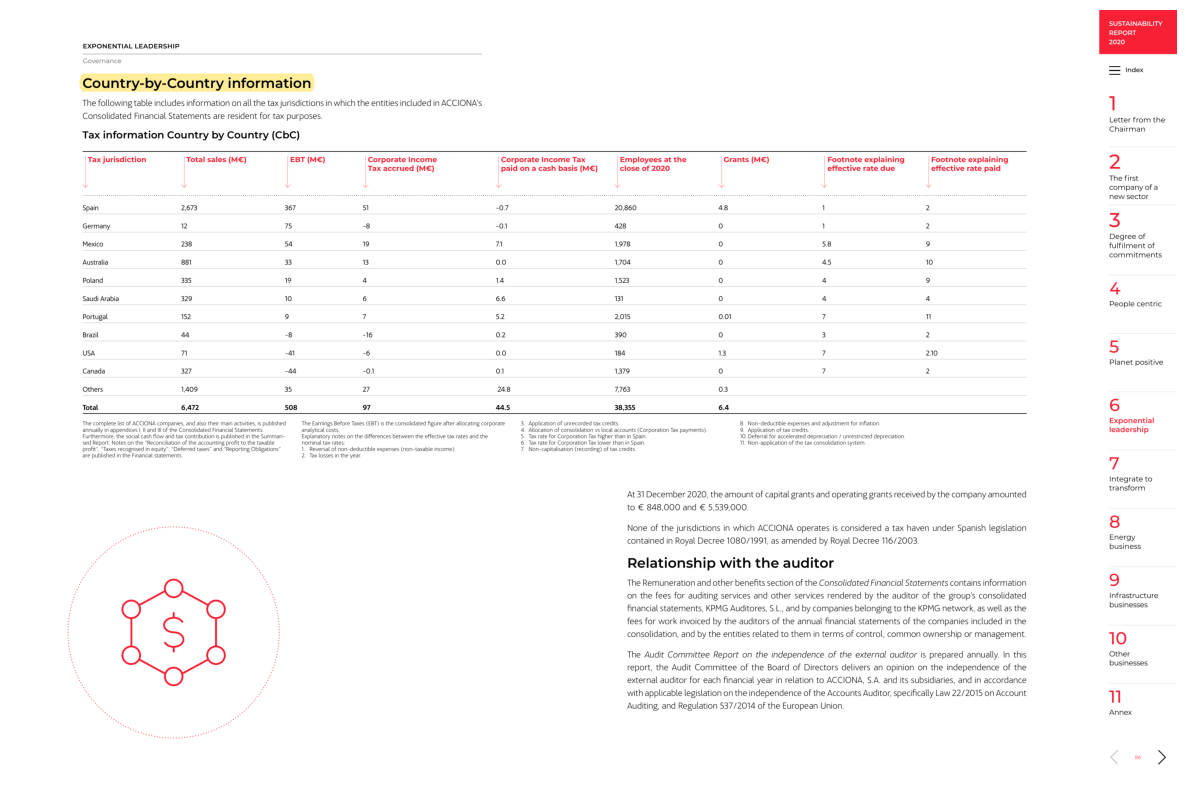

In [ ]:
#@title Analyze Layout (Detectron2)
from unstructured_inference.models.base import get_model

model = get_model("detectron2_onnx")

pages = []
for i, path in enumerate(image_paths):
  with Image.open(path) as image:
      page = PageLayout.from_image(
          image,
          number=i + 1,
          document_filename=file_path,
          fixed_layout=None,
          image_path=path,
          detection_model=model
      )
      pages.append(page)

for page in pages:
  tables = [e for e in page.elements if e.type == "Table"]
  image = Image.open(page.image_path).convert("RGB")
  plot_results(image, tables)